# Modelo ARIMA


## Introdução

O modelo ARIMA (AutoRegressive Integrated Moving Average) é uma generalização do modelo ARMA (AutoRegressive Moving Average) que inclui a diferenciação de séries temporais. O modelo ARIMA é representado por três parâmetros: $p, d$ e $q$, que são os números de termos autorregressivos, a ordem de diferenciação e o número de termos de média móvel, respectivamente.

O modelo ARIMA é um dos modelos mais utilizados para previsão de séries temporais, e é amplamente utilizado em diversas áreas, como finanças, economia, meteorologia, entre outras.

A integração no contexto do modelo ARIMA é o processo de acumular valores da série temporal, enquanto a diferenciação é o processo de remover tendências ou padrões de não-estacionaridade. Integração e diferenciação são processos opostos.

- Diferenciação: O processo de diferenciação transforma uma série não estacionária em uma série estacionária, subtraindo o valor anterior da série para remover tendências de longo prazo. O número de vezes que isso é feito é indicado pelo parâmetro $d$

$$
Y'_t = Y_t - Y_{t-1}
$$
Para uma série que requer diferenciação de ordem $d$, o processo é repetido $d$ vezes até que a série se torne estacionária.

- Integração: Quando falamos em "integração" no modelo ARIMA, estamos nos referindo ao processo inverso da diferenciação, que reconstrói a série original a partir de uma série diferenciada. O termo "integrado" no ARIMA refere-se à capacidade do modelo de prever uma série que foi diferenciada para alcançar a estacionaridade.




## Implementação em Python

In [1]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## Forecasting com ARIMA(p,d,q) 

Aqui vamos usar os dados trimestrais de geração de energia eletria na Australia. 

In [3]:
df = pd.read_csv('../data/qauselec.csv', index_col=0)
df.head()

,time,value
1,1956.00,3.923
2,1956.25,4.436
3,1956.50,4.806
4,1956.75,4.418
5,1957.00,4.339


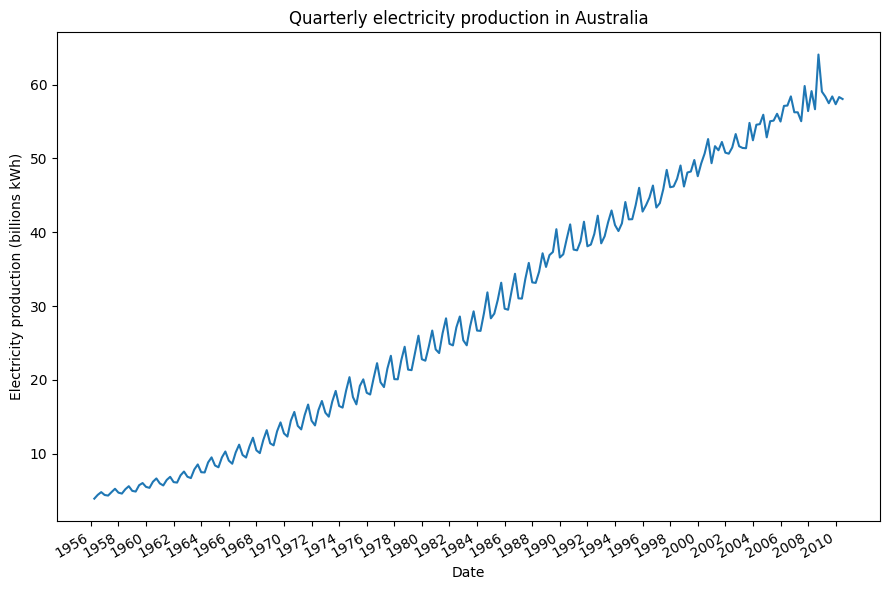

In [4]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity production (billions kWh)')

plt.xticks(np.arange(0, 218, 8), np.arange(1956, 2012, 2))

plt.title('Quarterly electricity production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

### Procedimento geral de modelagem 

#### Achar o valor de $d$ 

In [5]:
ad_fuller_result = adfuller(df['value'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.996327722990561
p-value: 0.9942270502497619


In [6]:
df_diff = np.diff(df['value'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.1727118466027764
p-value: 0.021619564130373827


#### Train/test split 

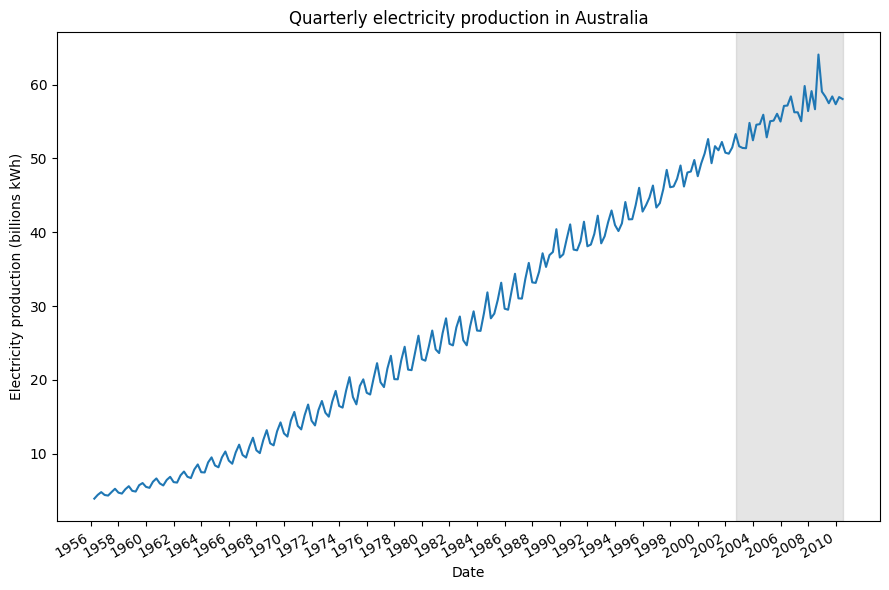

In [7]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity production (billions kWh)')
ax.axvspan(187, 218, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 218, 8), np.arange(1956, 2012, 2))

plt.title('Quarterly electricity production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
train = df['value'][:-32]
test = df.iloc[-32:]

In [9]:
def ARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, d):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    
    all_orders = list(product(all_p, all_q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1])).fit()
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

#### Seleção de modelo usando a metrica AIC 

In [10]:
result_df = ARIMA_gridsearch(train, 0, 4, 0, 4, 1)
result_df.head()

Fitting 25 unique models


  0%|          | 0/25 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98215D+00    |proj g|=  3.03355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.303D-06   1.982D+00
  F =   1.9821434096980373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40920D+00    |proj g|=  8.99313D-01

At iterate    5    f=  1.87584D+00    |proj g|=  2.20534D-02

At iterate   10    f=  1.87556D+00    |proj g|=  2.47069D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.471D-07   1.876D+00
  F =   1.8755641777438063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72739D+00    |proj g|=  7.23791D-03

At iterate    5    f=  1.72733D+00    |proj g|=  8.70459D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   8.705D-06   1.727D+00
  F =   1.7273334232475543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.28733D+00    |proj g|=  4.26714D-02

At iterate   30    f=  1.28533D+00    |proj g|=  6.04145D-01

At iterate   35    f=  1.28388D+00    |proj g|=  9.77749D-02

At iterate   40    f=  1.28375D+00    |proj g|=  2.85587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     49      1     0     0   2.417D-05   1.284D+00
  F =   1.2837447787822756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50502D+00    |proj g|=  5.70057D-01

At iterate    5    f=  1.27250D+00    |proj g|=  3.30851D-01

At iterate   10    f=  1.17261D+00    |proj g|=  7.24637D-02

At iterate   15    f=  1.12453D+00    |proj g|=  3.12048D-01

At iterate   20    f=  1.08236D+00    |proj g|=  7.13215D-02

At iterate   25    f=  1.07512D+00    |proj g|=  2.59881D-02

At iterate   30    f=  1.07510D+00    |proj g|=  3.14471D-03

At iterate   35    f=  1.07507D+00    |proj g|=  5.75719D-03

At iterate   40    f=  1.07506D+00    |proj g|=  2.39013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.10557D+00    |proj g|=  2.53770D-01

At iterate   20    f=  1.09367D+00    |proj g|=  7.64437D-02

At iterate   25    f=  1.09279D+00    |proj g|=  3.75873D-02

At iterate   30    f=  1.09016D+00    |proj g|=  8.49702D-02

At iterate   35    f=  1.08425D+00    |proj g|=  2.75569D-01

At iterate   40    f=  1.08314D+00    |proj g|=  1.53959D-02

At iterate   45    f=  1.08312D+00    |proj g|=  5.15289D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     62      1     0     0   5.154D-04   1.083D+00
  F =   1.0831178546252578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29348D+00    |proj g|=  1.95559D+00

At iterate    5    f=  1.17976D+00    |proj g|=  1.38286D+00

At iterate   10    f=  1.06399D+00    |proj g|=  1.27304D+00

At iterate   15    f=  1.00452D+00    |proj g|=  2.62886D-01

At iterate   20    f=  9.54922D-01    |proj g|=  9.08891D-02

At iterate   25    f=  9.41487D-01    |proj g|=  4.20908D-01

At iterate   30    f=  9.34356D-01    |proj g|=  5.99726D-01

At iterate   35    f=  9.32741D-01    |proj g|=  6.56028D-02

At iterate   40    f=  9.32345D-01    |proj g|=  4.29139D-02

At iterate   45    f=  9.32088D-01    |proj g|=  2.11328D-02

At iterate   50    f=  9.31772D-01    |proj g|=  2.32125D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06122D-01    |proj g|=  7.51659D-02

At iterate    5    f=  8.99334D-01    |proj g|=  7.79252D-02

At iterate   10    f=  8.97856D-01    |proj g|=  1.76455D-02

At iterate   15    f=  8.94530D-01    |proj g|=  5.49556D-02

At iterate   20    f=  8.91199D-01    |proj g|=  1.20765D-01

At iterate   25    f=  8.89285D-01    |proj g|=  6.26932D-02

At iterate   30    f=  8.88284D-01    |proj g|=  3.99931D-02

At iterate   35    f=  8.87630D-01    |proj g|=  4.85206D-03

At iterate   40    f=  8.86475D-01    |proj g|=  1.00828D-02

At iterate   45    f=  8.86369D-01    |proj g|=  4.02391D-03

At iterate   50    f=  8.86128D-01    |proj g|=  1.69679D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


,"(p,q)",AIC
0,"(4, 4)",309.329797
1,"(4, 3)",326.858270
2,"(4, 2)",343.639728
3,"(4, 1)",348.707306
4,"(3, 4)",357.081590


In [11]:
model = SARIMAX(train, order=(4,1,4), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  186
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -145.665
Date:                Tue, 24 Sep 2024   AIC                            309.330
Time:                        15:33:41   BIC                            338.313
Sample:                             0   HQIC                           321.076
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0175      0.024     -0.746      0.456      -0.064       0.029
ar.L2         -0.0207      0.023     -0.897      0.370      -0.066       0.025
ar.L3         -0.0185      0.024     -0.769      0.4

#### Analise de residos

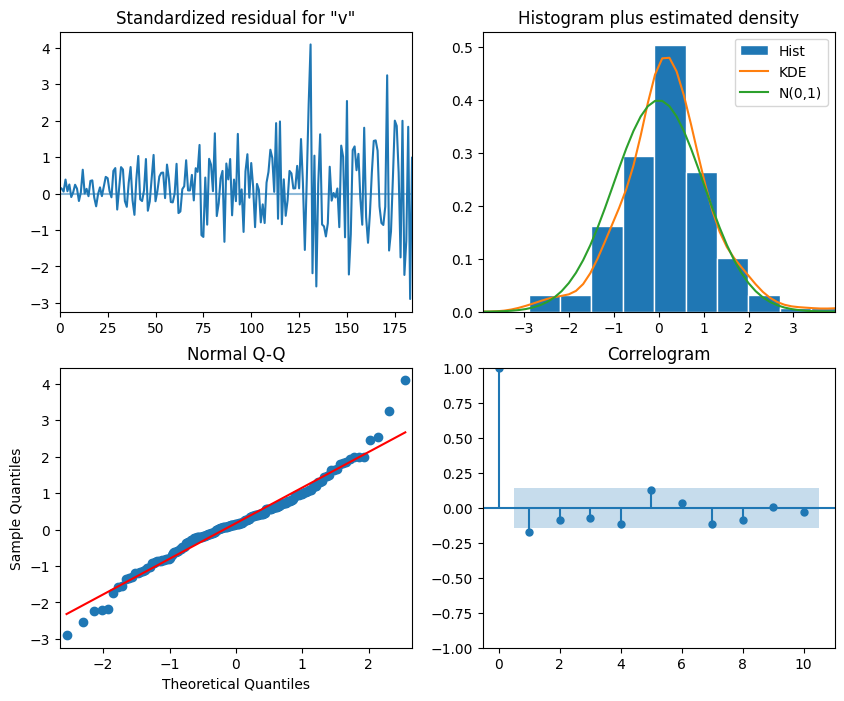

In [12]:
model_fit.plot_diagnostics(figsize=(10,8));

In [13]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('One p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


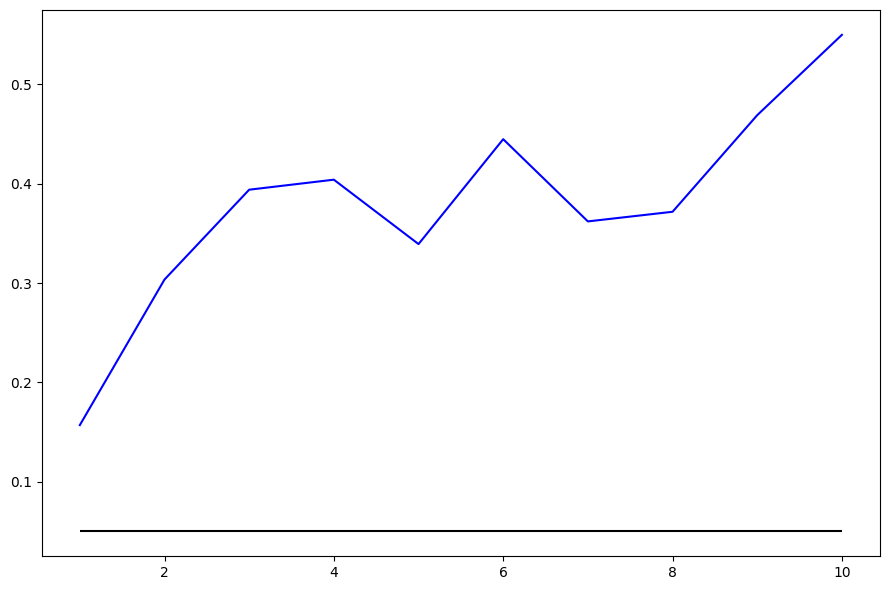

In [14]:
residuals = model_fit.resid

ljung_box_test(residuals, False, None)

#### Forecasting 

In [15]:
def rolling_predictions(df, train_len, horizon, window, period, method):
    
    TOTAL_LEN = train_len + horizon
    
    seasonal_steps = int((window/period))
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value[:horizon]
    
    elif method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    if method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(4,1,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA[:horizon]

In [16]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)

windows = [4, 8, 16, 32]

for window in windows:

    pred_mean = rolling_predictions(df['value'], TRAIN_LEN, HORIZON, window, 4, 'mean')
    pred_last_season = rolling_predictions(df['value'], TRAIN_LEN, HORIZON, window, 4, 'last_season')
    pred_ARIMA = rolling_predictions(df['value'], TRAIN_LEN, HORIZON, window, 4, 'ARIMA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_season_{window}'] = pred_last_season
    pred_df[f'pred_ARIMA_{window}'] = pred_ARIMA

pred_df.head()

,time,value,pred_mean_4,pred_last_season_4,pred_ARIMA_4,pred_mean_8,pred_last_season_8,pred_ARIMA_8,pred_mean_16,pred_last_season_16,pred_ARIMA_16,pred_mean_32,pred_last_season_32,pred_ARIMA_32
187,2002.50,53.299,24.806237,52.226,53.107479,24.806237,52.226,53.107479,24.806237,52.226,53.107479,24.806237,52.226,53.107479
188,2002.75,51.646,24.806237,50.778,50.863760,24.806237,50.778,50.863760,24.806237,50.778,50.863760,24.806237,50.778,50.863760
189,2003.00,51.415,24.806237,50.639,51.719677,24.806237,50.639,51.719677,24.806237,50.639,51.719677,24.806237,50.639,51.719677
190,2003.25,51.379,24.806237,51.486,52.226783,24.806237,51.486,52.226783,24.806237,51.486,52.226783,24.806237,51.486,52.226783
191,2003.50,54.808,25.377363,53.299,53.302828,24.806237,52.226,53.826284,24.806237,52.226,53.826284,24.806237,52.226,53.826284


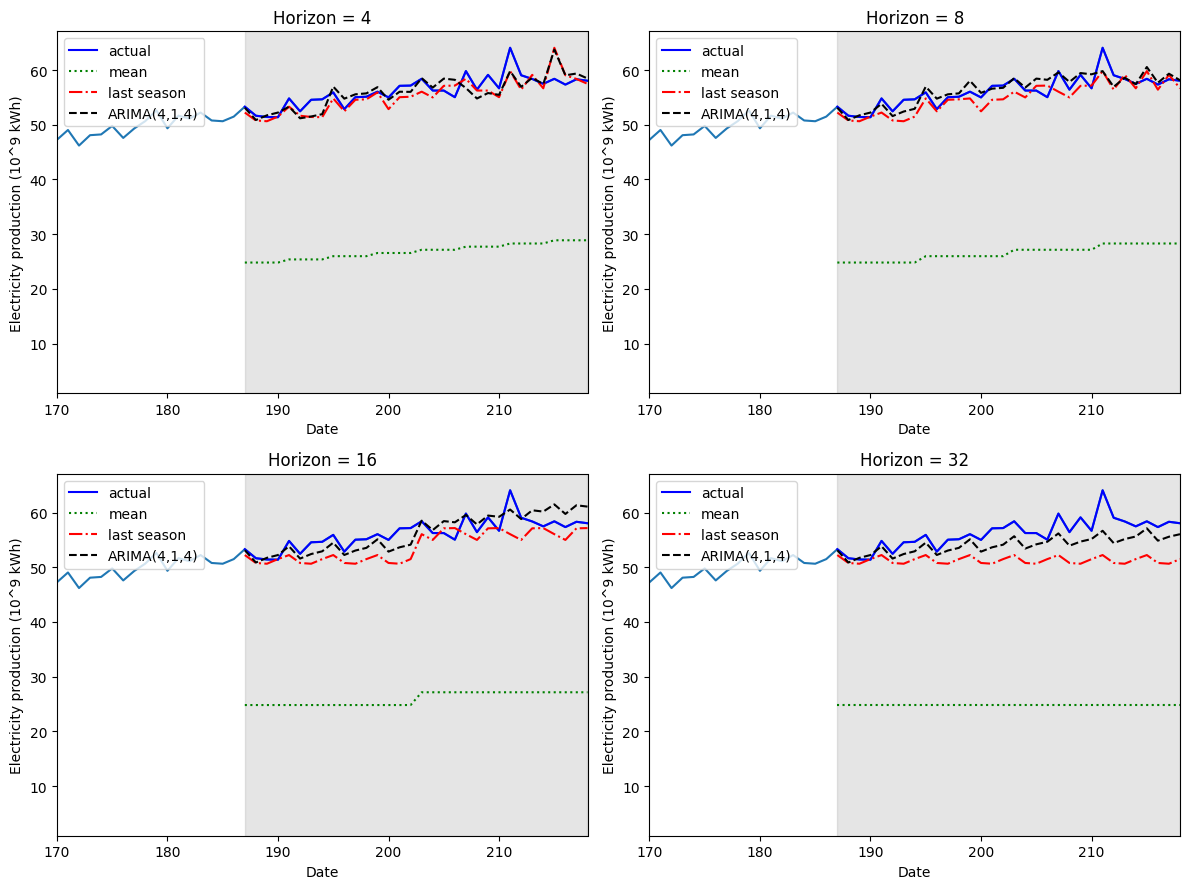

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_season_{windows[i]}'], 'r-.', label='last season')
    ax.plot(pred_df[f'pred_ARIMA_{windows[i]}'], 'k--', label='ARIMA(4,1,4)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Electricity production (10^9 kWh)')
    ax.axvspan(187, 218, color='#808080', alpha=0.2)
    ax.set_xlim(170, 218)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

#### Evaluação

In [18]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [19]:
mape_naive_seasonal_4 = mape(pred_df['value'], pred_df['pred_last_season_4'])
mape_ARIMA_4 = mape(pred_df['value'], pred_df['pred_ARIMA_4'])

mape_naive_seasonal_8 = mape(pred_df['value'], pred_df['pred_last_season_8'])
mape_ARIMA_8 = mape(pred_df['value'], pred_df['pred_ARIMA_8'])

mape_naive_seasonal_16 = mape(pred_df['value'], pred_df['pred_last_season_16'])
mape_ARIMA_16 = mape(pred_df['value'], pred_df['pred_ARIMA_16'])

mape_naive_seasonal_32 = mape(pred_df['value'], pred_df['pred_last_season_32'])
mape_ARIMA_32 = mape(pred_df['value'], pred_df['pred_ARIMA_32'])

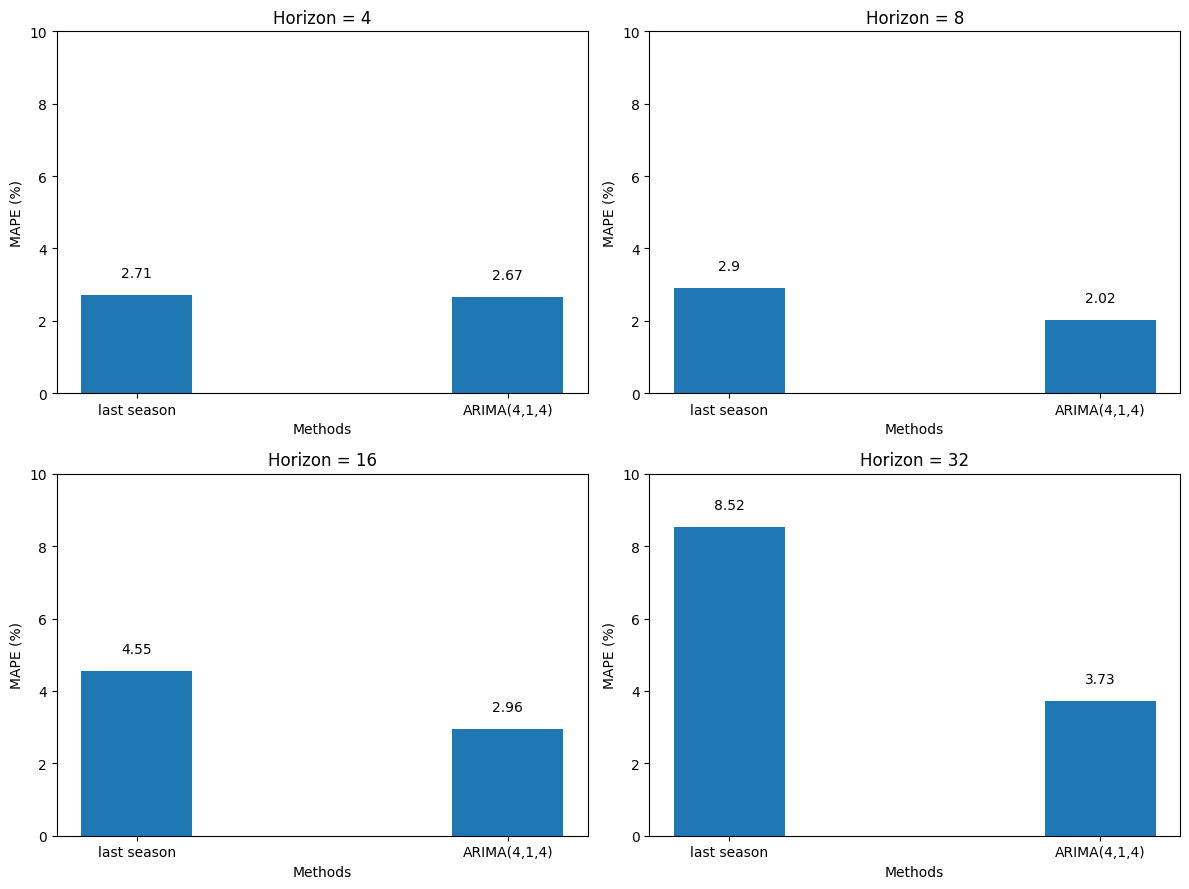

In [20]:
mapes_naive_seasonal = [mape_naive_seasonal_4, mape_naive_seasonal_8, mape_naive_seasonal_16, mape_naive_seasonal_32]
mapes_ARIMA = [mape_ARIMA_4, mape_ARIMA_8, mape_ARIMA_16, mape_ARIMA_32]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['last season', 'ARIMA(4,1,4)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [mapes_naive_seasonal[i], mapes_ARIMA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, 10)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+0.5, s=str(value), ha='center')

plt.tight_layout()